In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
'''
#분위수 기준 클러스터링
#parks_df = pd.read_csv("src/RF_parksdf_weekday.csv")
parks_df = pd.read_csv("src/RF_parksdf_saturday.csv")
#parks_df = pd.read_csv("src/RF_parksdf_holiday.csv")
parks_df.columns

parks_df["complaints_r300"].quantile(q=0.25) #788
parks_df["complaints_r300"].quantile(q=0.5) #1441
parks_df["complaints_r300"].quantile(q=0.75) #2816
#parks_df.loc[parks_df["complaints_r300"]>=10000]

parks_df["complaint_level"] = pd.qcut(
    parks_df["complaints_r300"],  # 민원 건수 열
    q=4,                          # 분위수: 4분위 (quartile) → 낮음/중간이하/중간이상/높음
    labels=["낮음", "중간이하", "중간이상", "높음"]
)
parks_df["complaint_level"].value_counts()
'''

complaint_level
낮음      353
중간이상    352
중간이하    350
높음      350
Name: count, dtype: int64

In [18]:
#자연발생 클러스터링(민원 단계 컬럼 생성)
from jenkspy import JenksNaturalBreaks

#parks_df = pd.read_csv("src/RF_parksdf_weekday.csv")
parks_df = pd.read_csv("src/RF_parksdf_saturday.csv")
#parks_df = pd.read_csv("src/RF_parksdf_holiday.csv")
parks_df.columns

i = 3

breaks = JenksNaturalBreaks(n_classes=i)
breaks.fit(parks_df["complaints_r300"])
print(breaks.breaks_)  # 구간 경계

parks_df["complaint_level"] = pd.cut(
    parks_df["complaints_r300"], bins=breaks.breaks_, labels=range(i), include_lowest=True
)
parks_df["complaint_level"].value_counts()

[0, 564, 1776, 5678]


complaint_level
0    1160
1     213
2      32
Name: count, dtype: int64

In [26]:
# KMeans 기반 클러스터링

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

#parks_df = pd.read_csv("src/RF_parksdf_weekday.csv")
parks_df = pd.read_csv("src/RF_parksdf_saturday.csv")
#parks_df = pd.read_csv("src/RF_parksdf_holiday.csv")
parks_df.columns

k = 4

X = parks_df["complaints_r300"].values.reshape(-1, 1)

kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(X)

centers = kmeans.cluster_centers_.flatten()
sorted_idx = np.argsort(centers)
label_map = {old: new for new, old in enumerate(sorted_idx)}
sorted_labels = np.vectorize(label_map.get)(clusters)

parks_df["complaint_level"] = sorted_labels

parks_df["complaint_level"].value_counts().sort_index()


complaint_level
0    1013
1     274
2      92
3      26
Name: count, dtype: int64

In [ ]:
# GMM 기반 클러스터링

import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture

#parks_df = pd.read_csv("src/RF_parksdf_weekday.csv")
parks_df = pd.read_csv("src/RF_parksdf_saturday.csv")
#parks_df = pd.read_csv("src/RF_parksdf_holiday.csv")
parks_df.columns

n_components = 4

X = parks_df["complaints_r300"].values.reshape(-1, 1)

gmm = GaussianMixture(n_components=n_components, random_state=0)
gmm.fit(X)
clusters = gmm.predict(X)

means = gmm.means_.flatten()
sorted_idx = np.argsort(means)
label_map = {old: new for new, old in enumerate(sorted_idx)}
sorted_labels = np.vectorize(label_map.get)(clusters)

parks_df["complaint_level"] = sorted_labels

parks_df["complaint_level"].value_counts().sort_index()


complaint_level
0    914
1    405
2     84
3      2
Name: count, dtype: int64

In [19]:
#범주형 변수의 label을 [0,1]로 변환
from sklearn.preprocessing import LabelEncoder

le_dict = {}
for col in ["parking_type", "operation_type", "Weekday_paid", "Saturday_paid", "Holiday_paid"]:
    le = LabelEncoder()
    parks_df[col] = le.fit_transform(parks_df[col])
    le_dict[col] = le  # 변수별로 인코더 저장

# 예시: parking_type의 범주와 정수 매핑 확인
print(list(le_dict["parking_type"].classes_))
print(list(le_dict["operation_type"].classes_))
print(list(le_dict["Weekday_paid"].classes_))
print(list(le_dict["Saturday_paid"].classes_))
print(list(le_dict["Holiday_paid"].classes_))
# [0, 1, 2, ...] 순서로 classes_에 저장됨
#['NS', 'NW'] -> [0,1]
#[1, 3] -> [0,1]
#['N', 'Y'] -> [0,1]
#['N', 'Y'] -> [0,1]
#['N', 'Y'] -> [0,1]

['NS', 'NW']
[1, 3]
['N', 'Y']
['N', 'Y']
['N', 'Y']


In [20]:
X = parks_df.drop(["complaints_r300", "complaint_level", "address"], axis=1)
y = parks_df["complaint_level"]

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf_full = RandomForestClassifier(random_state=0)
rf_full.fit(X_train_full, y_train)

# 중요도 기반 상위 10개 변수 선택
importances = pd.Series(rf_full.feature_importances_, index=X.columns)
top10_features = importances.sort_values(ascending=False).head(9).index.tolist()

X_new = X[top10_features]

print("X_new 변수 목록:", top10_features)

X_new 변수 목록: ['total_parking_spaces', 'bus_r300', 'cctv_r300', 'base_parking_fee', 'fee1H', 'additional_unit_fee', 'Weekday_end', 'Holiday_start', 'Saturday_end']


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/9, random_state = 42)

X_new.columns

Index(['total_parking_spaces', 'bus_r300', 'cctv_r300', 'base_parking_fee',
       'fee1H', 'additional_unit_fee', 'Weekday_end', 'Holiday_start',
       'Saturday_end'],
      dtype='object')

In [8]:
'''
X_new = X[["bus_r300", "total_parking_spaces","cctv_r300", 
           "fee1H","base_parking_fee", "additional_unit_fee", "Weekday_operatingHours",
            "Weekday_end", "additional_unit_time","Saturday_operatingHours",
            "Saturday_end"]]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/9, random_state = 42)

X_new.columns
'''

'\nX_new = X[["bus_r300", "total_parking_spaces","cctv_r300", \n           "fee1H","base_parking_fee", "additional_unit_fee", "Weekday_operatingHours",\n            "Weekday_end", "additional_unit_time","Saturday_operatingHours",\n            "Saturday_end"]]\n\nX_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.1, random_state = 42)\nX_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/9, random_state = 42)\n\nX_new.columns\n'

In [22]:
#robust scalar 적용 cell인데 효과 없음
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import robust_scale

transformer = RobustScaler()
X_robust = transformer.fit_transform(X_new)
X_robust = robust_scale(X_robust)

X_train, X_test, y_train, y_test = train_test_split(X_robust, y, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/9, random_state = 42)

In [23]:
# 랜덤포레스트 
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.8936


In [8]:
# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('gradient boosting 정확도: {:.4f}'.format(accuracy))

gradient boosting 정확도: 0.8298


In [9]:
# XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('XGBoost 정확도: {:.4f}'.format(accuracy))

XGBoost 정확도: 0.8298


In [24]:
importances = rf.feature_importances_
feature_names = X_new.columns  # DataFrame에서 feature 이름 추출

# 중요도 표 만들기
importance_table = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

importance_table


,feature,importance
0,total_parking_spaces,0.211276
1,bus_r300,0.178228
2,cctv_r300,0.136614
3,base_parking_fee,0.094415
4,fee1H,0.089592
7,Holiday_start,0.082136
6,Weekday_end,0.080920
5,additional_unit_fee,0.065025
8,Saturday_end,0.061794


In [25]:
from sklearn.metrics import mean_squared_error

val_predict = rf.predict(X_val)
val_predict

test_predict = rf.predict(X_test)

mean_squared_error(y_test, val_predict)

0.3546099290780142

In [26]:
# Accuracy 분석

from sklearn.metrics import classification_report, accuracy_score

print("Complaint Level (Jenks) Classification Accuracy:", round(accuracy_score(y_test, pred), 3))
print(classification_report(y_test, pred, target_names=['Low', 'Mid', 'High']))

Complaint Level (Jenks) Classification Accuracy: 0.894
              precision    recall  f1-score   support

         Low       0.91      0.97      0.94       118
         Mid       0.75      0.45      0.56        20
        High       1.00      0.67      0.80         3

    accuracy                           0.89       141
   macro avg       0.89      0.70      0.77       141
weighted avg       0.89      0.89      0.88       141



In [14]:
#최적 하이퍼 파라미터를 찾았는데 기존 모델보다 성능 낮아짐..
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [500, 1000],
           'max_depth' : [6, 8, 10],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [3, 5]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 1000}
최고 예측 정확도: 0.7498


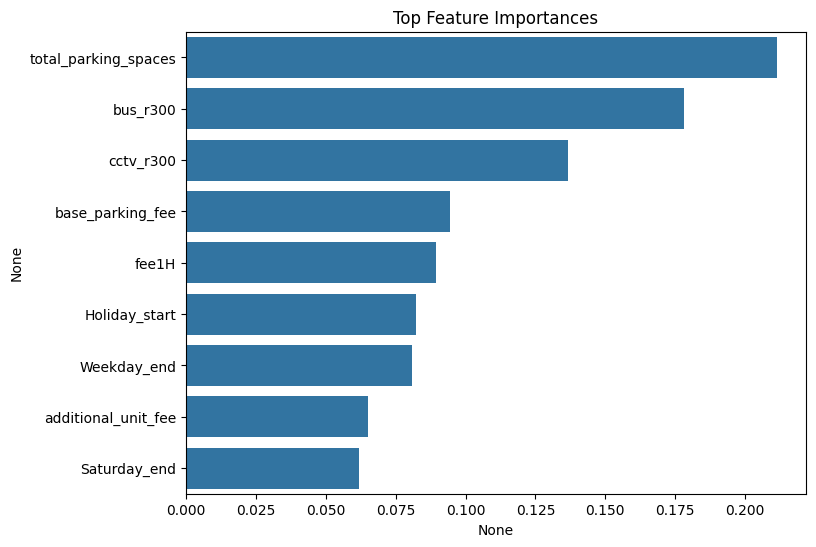

In [27]:
# 변수 중요도 플로팅
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_new.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [ ]:
# train data
X_new.head

<bound method NDFrame.head of       bus_r300  total_parking_spaces  cctv_r300  fee1H  base_parking_fee  \
0            1                   132          0   2400               200   
1            1                    97          0   2400               200   
2            5                   194          3   2400               200   
3            4                   168          2   1200               100   
4            7                   149          2   2400               200   
...        ...                   ...        ...    ...               ...   
1400         8                   130          3   1200               100   
1401        17                     4          1   3000               250   
1402         6                     1          2   1200               100   
1403         5                     1          1    600               600   
1404         7                     1          4    600               600   

      additional_unit_fee  Weekday_operatingHours  Weekda